In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pickle


In [16]:
#df = pd.read_csv(r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\plank_model\data\plank_dataset_full.csv")
df = pd.read_csv(r"C:\Users\PORTABLE\Desktop\projet_annuel\core\plank_model\data\plank_dataset_full.csv")
print(df.shape)
df.head()


(3935, 133)


,label,x0,y0,z0,v0,x1,y1,z1,v1,x2,...,z30,v30,x31,y31,z31,v31,x32,y32,z32,v32
0,0,0.830130,0.351851,-0.025262,0.999119,0.850655,0.345155,-0.014917,0.999088,0.851492,...,-0.051480,0.831482,0.031709,0.376000,0.180639,0.640694,0.002836,0.391812,-0.140807,0.875498
1,0,0.827971,0.351691,-0.026928,0.999033,0.848859,0.345107,-0.015630,0.999009,0.849683,...,-0.075619,0.827558,0.033213,0.375629,0.180146,0.626701,0.011874,0.391841,-0.171767,0.869638
2,0,0.826663,0.350897,-0.034896,0.998833,0.848075,0.344515,-0.022585,0.998824,0.848937,...,-0.074106,0.822614,0.033985,0.374774,0.204634,0.610258,0.014278,0.392639,-0.170130,0.862897
3,0,0.825896,0.350415,-0.040929,0.998722,0.847541,0.344141,-0.028329,0.998713,0.848437,...,-0.060950,0.820857,0.037479,0.374753,0.218800,0.599725,0.018048,0.393976,-0.154337,0.859343
4,0,0.825994,0.350126,-0.047208,0.998716,0.847727,0.343751,-0.034991,0.998706,0.848619,...,-0.061091,0.820887,0.038908,0.374778,0.217422,0.595844,0.021588,0.394186,-0.154317,0.858819


In [ ]:
# Load ALREADY-SPLIT datasets (SOURCE OF TRUTH)
train_df = pd.read_csv(r"C:\Users\PORTABLE\Desktop\projet_annuel\core/plank_model/data/plank_train_full.csv")
test_df  = pd.read_csv(r"C:\Users\PORTABLE\Desktop\projet_annuel\core/plank_model/data/plank_test_full.csv")

X_train = train_df.drop("label", axis=1).values.astype(np.float32)
y_train = train_df["label"].values.astype(np.float32)

X_test = test_df.drop("label", axis=1).values.astype(np.float32)
y_test = test_df["label"].values.astype(np.float32)

# Fit scaler ONLY on TRAIN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Save scaler for live
with open(r"C:\Users\PORTABLE\Desktop\projet_annuel\core/plank_model/model/scaler_full.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Torch tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32)




TRAIN: torch.Size([3148, 132]) TEST: torch.Size([787, 132])
Label distrib train: (array([0., 1.], dtype=float32), array([2145, 1003]))
Label distrib test : (array([0., 1.], dtype=float32), array([536, 251]))


In [26]:
# SANITY CHECK
print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
print("Label distrib train:", np.unique(y_train.numpy(), return_counts=True))
print("Label distrib test :", np.unique(y_test.numpy(), return_counts=True))

print("TRAIN SHAPE:", X_train.shape)
print("TEST  SHAPE:", X_test.shape)
print("TRAIN LABELS:", np.unique(y_train.numpy(), return_counts=True))
print("TEST  LABELS:", np.unique(y_test.numpy(), return_counts=True))
print("NaNs:", np.isnan(X_train.numpy()).any())
print("Infs:", np.isinf(X_train.numpy()).any())

TRAIN: torch.Size([3148, 132]) TEST: torch.Size([787, 132])
Label distrib train: (array([0., 1.], dtype=float32), array([2145, 1003]))
Label distrib test : (array([0., 1.], dtype=float32), array([536, 251]))
TRAIN SHAPE: torch.Size([3148, 132])
TEST  SHAPE: torch.Size([787, 132])
TRAIN LABELS: (array([0., 1.], dtype=float32), array([2145, 1003]))
TEST  LABELS: (array([0., 1.], dtype=float32), array([536, 251]))
NaNs: False
Infs: False


In [27]:
class MLP_Full(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_Full(input_dim=X_train.shape[1])


In [28]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [29]:
EPOCHS = 20

train_losses, val_losses = [], []

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb).squeeze()
            val_loss += loss_fn(pred, yb).item()

    train_losses.append(total_loss/len(train_loader))
    val_losses.append(val_loss/len(test_loader))

    print(f"{epoch+1}: train={train_losses[-1]:.4f} | val={val_losses[-1]:.4f}")


1: train=0.2275 | val=0.0651
2: train=0.0680 | val=0.0224
3: train=0.0431 | val=0.0156
4: train=0.0287 | val=0.0057
5: train=0.0222 | val=0.0031
6: train=0.0143 | val=0.0029
7: train=0.0121 | val=0.0026
8: train=0.0076 | val=0.0008
9: train=0.0090 | val=0.0010
10: train=0.0137 | val=0.0051
11: train=0.0204 | val=0.0012
12: train=0.0059 | val=0.0005
13: train=0.0033 | val=0.0004
14: train=0.0103 | val=0.0017
15: train=0.0109 | val=0.0022
16: train=0.0113 | val=0.0090
17: train=0.0128 | val=0.0015
18: train=0.0021 | val=0.0003
19: train=0.0030 | val=0.0011
20: train=0.0052 | val=0.0016


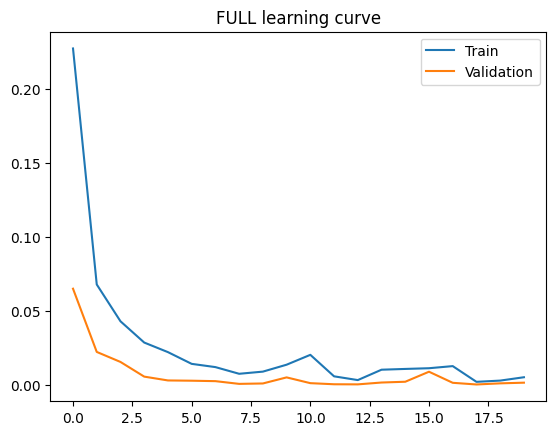

In [33]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train","Validation"])
plt.title("FULL learning curve")
plt.show()

In [34]:
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze()
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

accuracy = (preds == y_test).float().mean()
print("Accuracy:", accuracy.item())

Accuracy: 0.9987293481826782


In [35]:
torch.save(model.state_dict(), r"C:\Users\PORTABLE\Desktop\projet_annuel\core\plank_model\model\plank_mlp_full.pt")
print("Modèle FULL sauvegardé.")

Modèle FULL sauvegardé.
